In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
import os
import vis_cpu
from astropy import constants, units
from astropy.time import Time
from astropy.coordinates import Longitude, Latitude, EarthLocation
from scipy.optimize import minimize
from scipy import special
from pyuvdata import UVBeam
from pyradiosky import SkyModel
from pyuvsim import AnalyticBeam
%matplotlib inline

In [2]:
beam_file = "NF_HERA_Dipole_efield_beam.fits"
beam = UVBeam.from_file(beam_file)
beam.interpolation_function = "az_za_simple"
beam.freq_interp_kind = "cubic"
beam.peak_normalize()
setattr(beam, "type", "NF_Dipole")

In [3]:
sep = 14.6
diameter = 10
array_layout = hera_sim.antpos.hex_array(3, sep=sep, outriggers=0, split_core=False)
n_freqs = 1
start_freq = 150e6
channel_width = 100e3
n_times = 70
start_time = 2458099.28
integration_time = 60 * 20
uvdata = hera_sim.io.empty_uvdata(
    array_layout=array_layout,
    Nfreqs=n_freqs,
    start_freq=start_freq,
    channel_width=channel_width,
    Ntimes=n_times,
    start_time=start_time,
    integration_time=integration_time,
#     polarization_array=np.array(['xx','yy']),
)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [37]:
lst = uvdata.lst_array[0]
n_side = 128
n_pix = healpy.nside2npix(n_side)
l_max = 3 * n_side - 1
ells = np.arange(0, l_max+1, dtype=float)
input_cov = 1 / (1+ells)**4
stokes = np.zeros((4,1,n_pix), dtype=float)
stokes[0,0] = healpy.synfast(input_cov, n_side)
if stokes.min() < 0:
    stokes[0,0] += np.abs(stokes[0,0].min())
max_intensity = 500 / hera_sim.utils.jansky_to_kelvin(0.15, 1)
rescaling = max_intensity / stokes.max()
stokes[0,0] *= rescaling

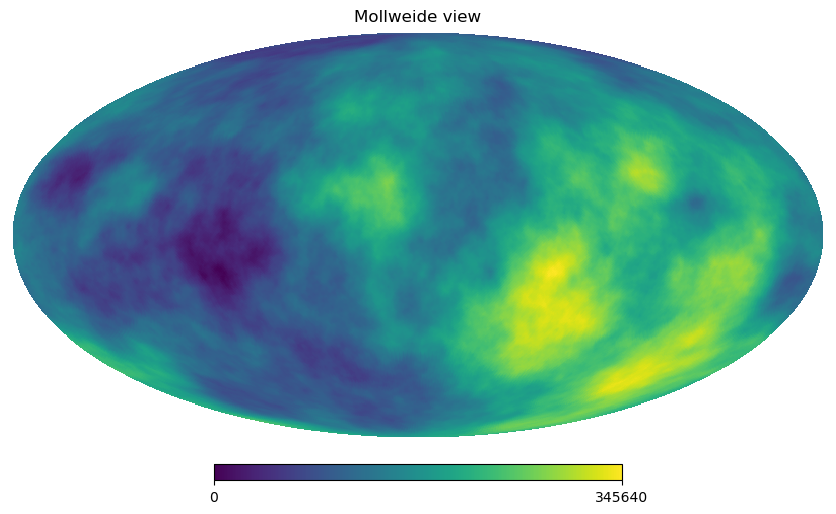

In [38]:
healpy.mollview(stokes[0,0])

In [6]:
sky_model = SkyModel(
    stokes=stokes*units.Jy/units.sr,
    spectral_type="flat",
    component_type="healpix",
    nside=n_side,
    hpx_inds=np.arange(n_pix),
)

In [7]:
beam_ids = [0,] * len(array_layout)

In [8]:
data_model = hera_sim.visibilities.ModelData(
    uvdata=uvdata,
    sky_model=sky_model,
    beam_ids=beam_ids,
    beams=[beam,],
)

In [9]:
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)

In [10]:
simulation.simulate();

In [11]:
reds, _, lens, conj = uvdata.get_redundancies(include_conjugates=True)
conj = set(conj)

In [12]:
data = []
ant_1_array = []
ant_2_array = []
edges = [0,]
idx = 0
min_length = np.sqrt(2) * diameter
for group, length in zip(reds, lens):
    if (length <= min_length) or (len(group) < 5):
        continue
    for bl in group:
        ai, aj = uvdata.baseline_to_antnums(bl)
        if bl in conj:
            ai, aj = aj, ai
        data.append(np.atleast_1d(uvdata.get_data(ai,aj,"xx").squeeze()))
        ant_1_array.append(ai)
        ant_2_array.append(aj)
        idx += 1
    edges.append(idx)
data = np.asarray(data).squeeze()
ant_1_array = np.asarray(ant_1_array)
ant_2_array = np.asarray(ant_2_array)
edges = np.asarray(edges)

In [13]:
data_cov = data @ data.T.conj() / n_times

In [14]:
pos, ants = uvdata.get_ENU_antpos()

In [15]:
snr = 1000
noise_amp = np.abs(data).max() / snr
noise = np.eye(uvdata.Nbls, dtype=complex) * noise_amp**2
noise_diag = np.diag(noise)

n_ants = ants.size
err = 0.05
re_gain = np.random.normal(loc=1, size=n_ants, scale=err)
im_gain = np.random.normal(loc=0, size=n_ants, scale=err)
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = re_gain
split_gains[1::2] = im_gain

In [16]:
lat, lon, _ = uvdata.telescope_location_lat_lon_alt
sky_alms = healpy.map2alm(0.5*stokes[0,0], use_pixel_weights=True)
healpy.rotate_alm(sky_alms, lon, np.pi/2-lat)
sky_power = healpy.anafast(healpy.alm2map(sky_alms, n_side), use_pixel_weights=True)

In [17]:
power_beam = beam.copy()
power_beam.efield_to_power()

In [18]:
ecef_antpos = uvdata.antenna_positions
enu_antpos = uvdata.get_ENU_antpos()[0]
uvws = uvdata.freq_array[0,0] * (
    enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
) / constants.c.value
za, az = healpy.pix2ang(n_side, np.arange(healpy.nside2npix(n_side)))
az = Longitude((az - np.pi/2)*units.rad).value
beam_vals = power_beam.interp(
    az_array=az,
    za_array=za, 
    freq_array=np.atleast_1d(uvdata.freq_array[0,0]),
)[0].squeeze()[0]
beam_vals[za>np.pi/2] = 0
local_crd = np.array(
    [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
)
fringe = np.exp(-2j * np.pi * uvws @ local_crd)
diff_mat =  np.zeros((edges[-1], edges.size - 1), dtype=complex)
ells = np.arange(sky_power.size)
scaling = 2 * ells + 1
for grp in range(diff_mat.shape[1]):
    start, stop = edges[grp:grp+2]
    fringed_beam = beam_vals * fringe[start]
    beam_spectrum = healpy.anafast(fringed_beam, use_pixel_weights=True)
    cov_amp = np.sum(sky_power * scaling * beam_spectrum)
    diff_mat[start:stop,grp] = np.sqrt(cov_amp)

Casting complex values to real discards the imaginary part


In [19]:
diff_cov = diff_mat @ diff_mat.T.conj()

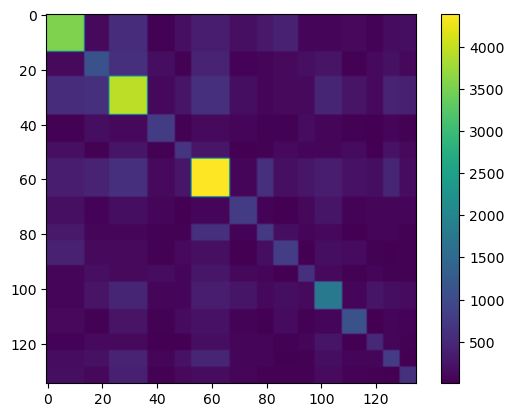

In [20]:
plt.imshow(np.abs(data_cov))
plt.colorbar()

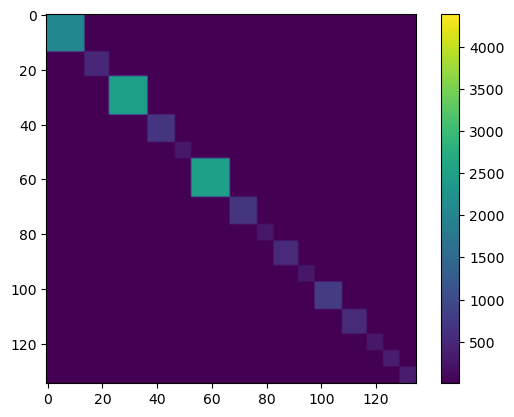

In [23]:
plt.imshow(np.abs(diff_cov), vmax=np.abs(data_cov).max(), vmin=np.abs(data_cov).min())
plt.colorbar()